In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import copy
import seaborn as sns
from pathlib import Path

In [144]:
path = Path().cwd()
dataPath = path / "data" / "HR_data.csv" #path.parent

data = pd.read_csv(dataPath)
set(data.dtypes)

data.sort_values(['Cohort', 'Round', 'Phase'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [145]:
# Import Data
Data_results = copy.copy(data.iloc[:,1:52])
types = ['Round','Phase','Cohort','Individual','Puzzler']
Data_type = copy.copy(data[types])
Data_answers = copy.copy(data.iloc[:,54:].drop(columns=types[2:]))

# Convert to int
for t in types[:3]:
    # print(set(Data_type[t]))
    Data_type[t] = Data_type[t].str[-1].astype(int)
Data_type

# Fill NaNs
Data_results = Data_results.fillna(Data_results.mean())
Data_answers = Data_answers.fillna(Data_answers.median())


# for d in [Data_results,Data_type,Data_answers]:
#     print(np.sum(d.isnull().any(axis=0)))

# ['Frustrated', 'upset', 'hostile', 'alert', 'ashamed', 'inspired','nervous', 'attentive', 'afraid', 'active', 'determined']

# Flip negative columns (this way, higher number -> positive semantic meaning)
pos_list = ['inspired','attentive','active','determined']
ten_list = ['Frustrated']

new_columns = {}
for col in Data_answers:
    if col in ten_list:
        Data_answers[col] = Data_answers[col].values/2
    if col not in pos_list:
        print(f'{col} is flipped')
        new_columns[col] = col + '_flip'
        Data_answers[col] = 5-Data_answers[col]
Data_answers.rename(columns=new_columns, inplace=True)


# Normalize within Cohort
Normalize_group = True

def normalize_by_group(df, group_col, method='zscore'):
    df_normalized = df.copy()
    numeric_cols = df.select_dtypes(include='number').columns
    if method == 'zscore':
        func = lambda x: (x - x.mean()) / x.std()
    elif method == 'submean':
        func = lambda x: (x - x.mean())
    elif method == 'minmax':
        func = lambda x: (x - x.min()) / (x.max() - x.min())
    else:
        raise ValueError("Unsupported method. Use 'zscore' or 'minmax'.")
    df_normalized[numeric_cols] = df.groupby(group_col)[numeric_cols].transform(func)
    return df_normalized

if Normalize_group:
    Data_results = normalize_by_group(Data_results, Data_type['Cohort'], method='zscore')

# Data_results

# Combine them logically (no merge)
df = Data_results.copy()
df['Cohort'] = Data_type['Cohort']
df['Round'] = Data_type['Round']

Data_mean_results = pd.DataFrame()
for col in Data_results:
    # Group and transform
    Data_mean_results[f'mean_{col}'] = df.groupby(['Cohort', 'Round'])[col].transform('mean')


real_answers = Data_answers.columns
Data_answers['mean'] = Data_answers[real_answers].mean(axis=1)
Data_answers['min'] = Data_answers[real_answers].min(axis=1)
Data_answers['max'] = Data_answers[real_answers].max(axis=1)

# Data_answers


Frustrated is flipped
upset is flipped
hostile is flipped
alert is flipped
ashamed is flipped
nervous is flipped
afraid is flipped


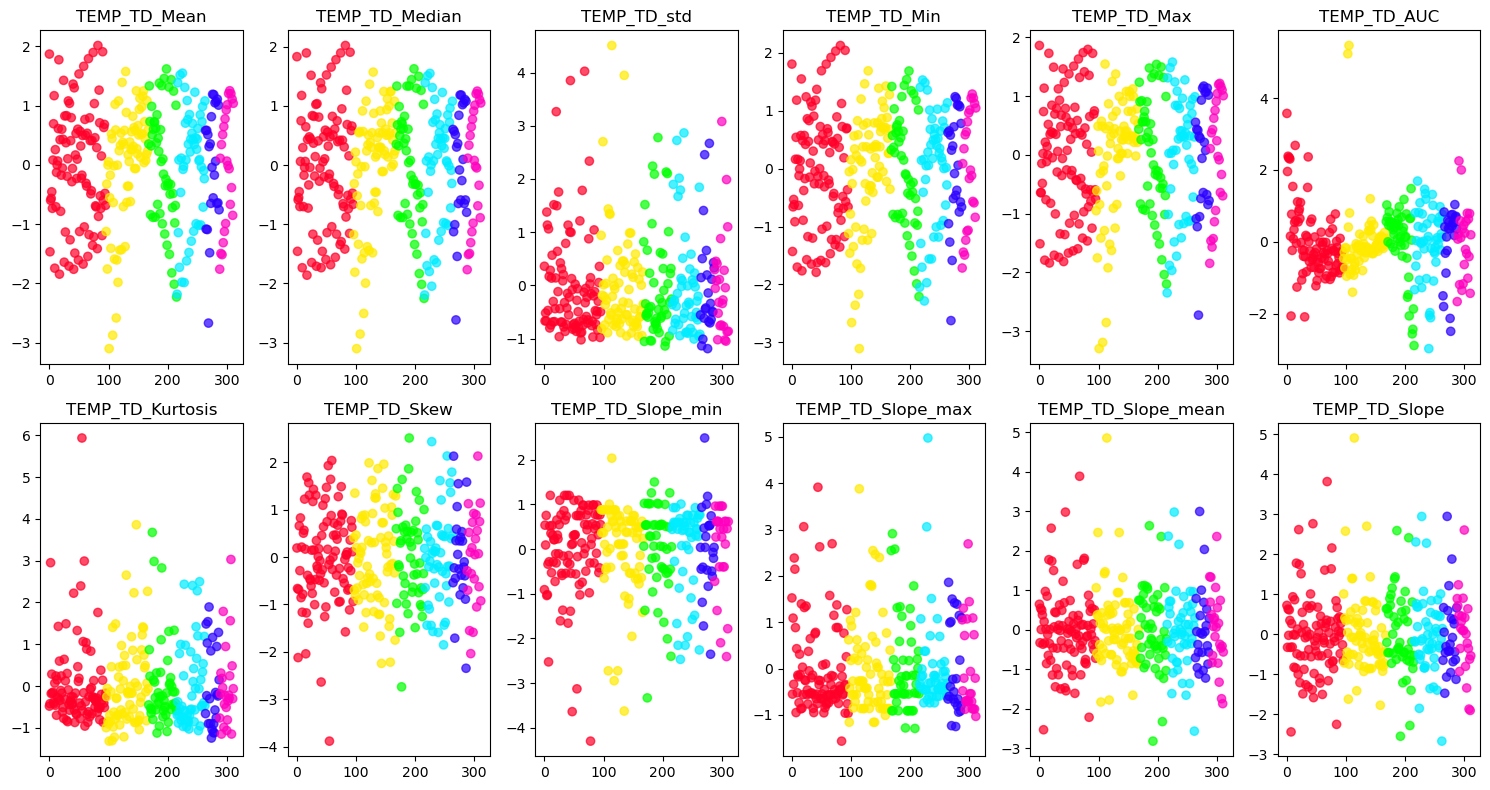

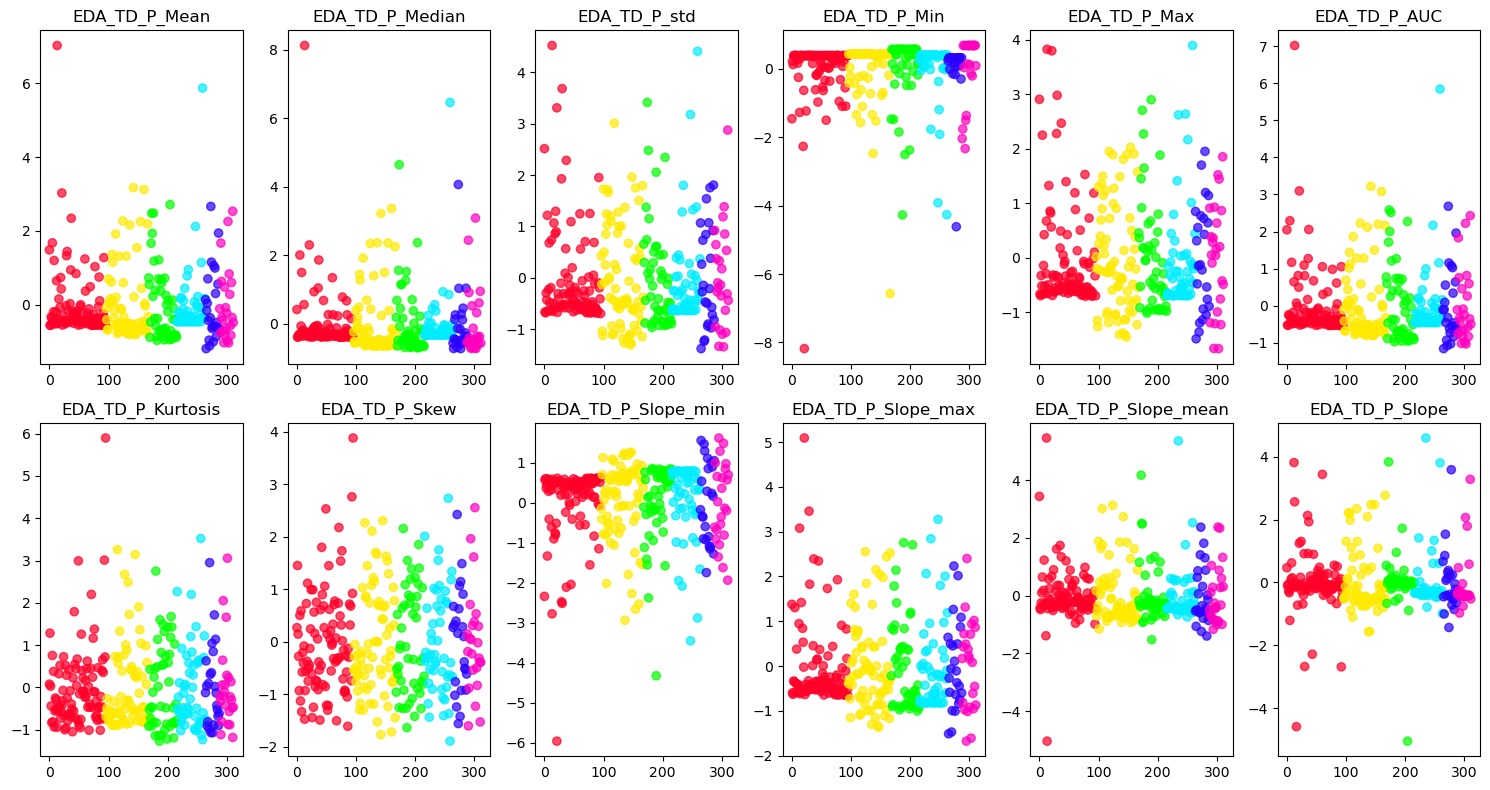

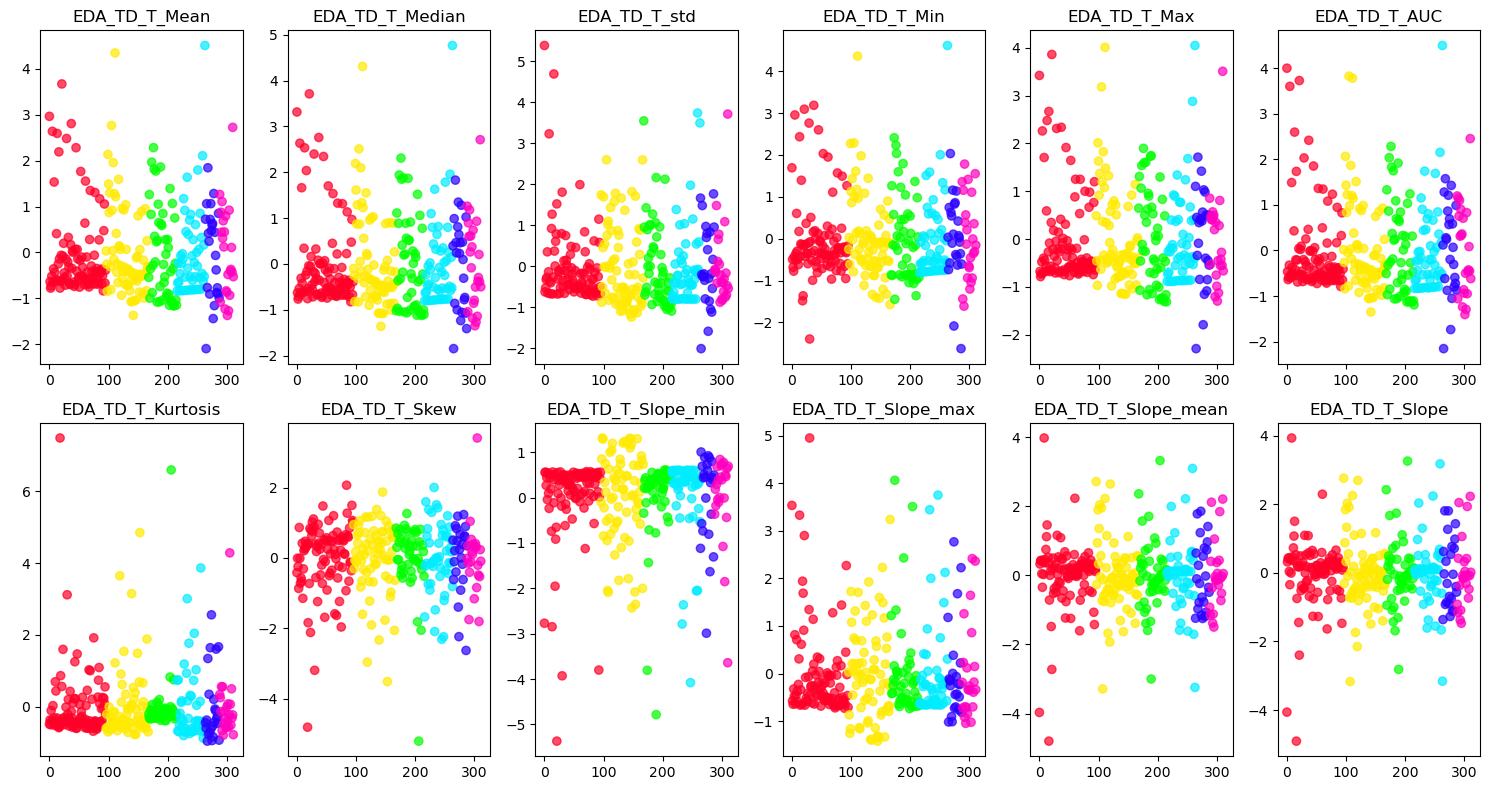

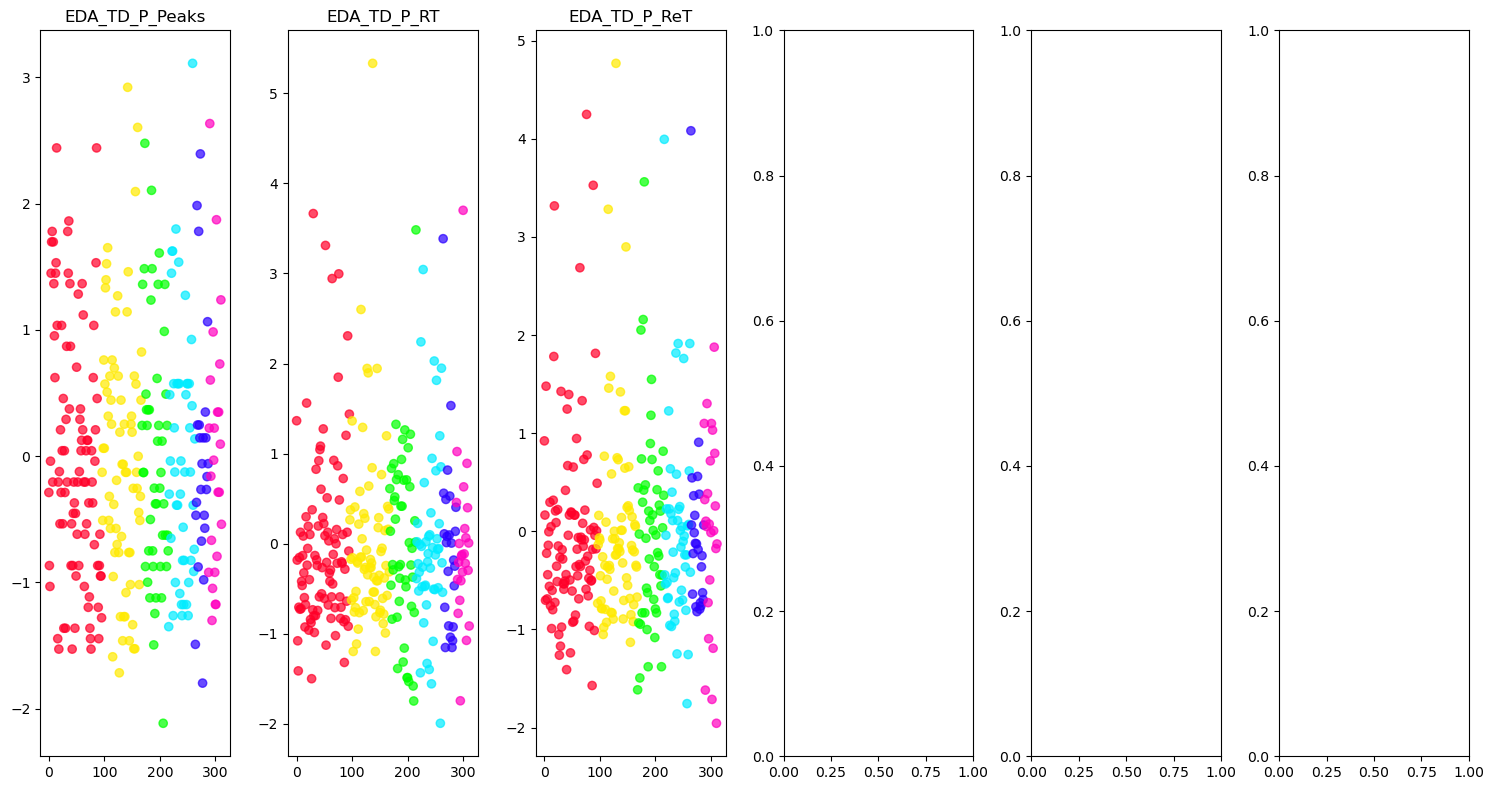

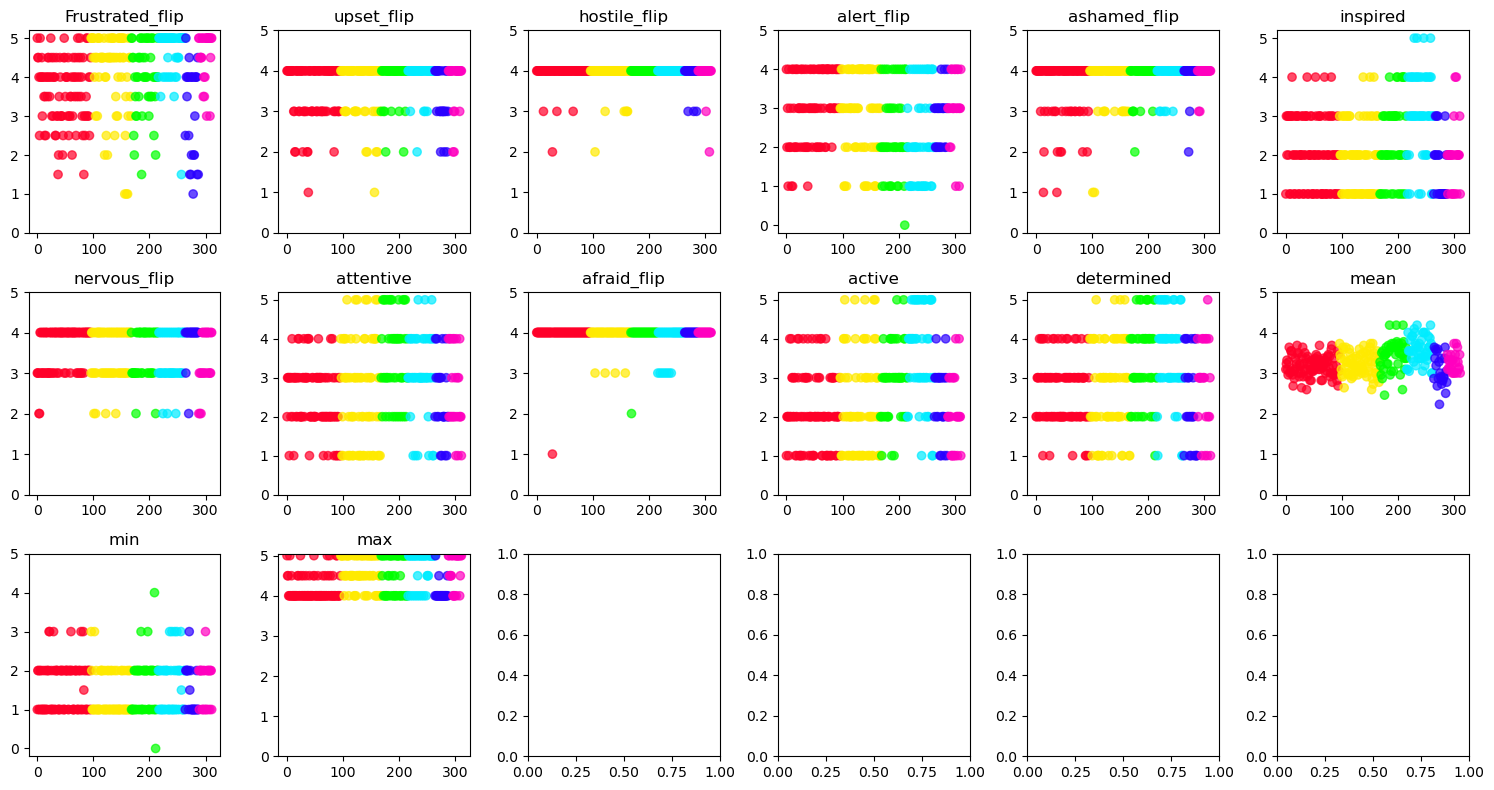

In [146]:
import math
def plotstuff(data,c=Data_type['Cohort'].values,fix=False):
    num_cols = 6
    fig, axes = plt.subplots(nrows= math.ceil(len(data.columns) / num_cols), ncols=num_cols, figsize=(15, 8)) 
    axes = axes.flatten()

    for i, col in enumerate(data.columns):
        ax = axes[i]
        
        scatter = ax.scatter(
            data.index, 
            data[col], 
            c = c,
            cmap='gist_rainbow',
            alpha=0.7
        )
        
        ax.set_title(col)
        if fix:
            ax.set_yticks(range(0, 6))

    plt.tight_layout()
    plt.show()

HR = range(0,12)
TEMP = range(12,24)
EDA_P = range(24,36)
EDA_T = range(36,48)
EDA_Rest = range(48,51)


'''plotstuff:
plot a dataframe colored by fx cohort or round
    example use:
--  plotstuff(Data_results.iloc[:,HR],c=Data_type['Cohort'])
->  plot data_results (HR colums) colored by cohort
'''

# plotstuff(Data_results.iloc[:,HR],c=Data_type['Round'])
plotstuff(Data_results.iloc[:,TEMP])
plotstuff(Data_results.iloc[:,EDA_P])
plotstuff(Data_results.iloc[:,EDA_T])
plotstuff(Data_results.iloc[:,EDA_Rest])

# plotstuff(Data_mean_results.iloc[:,TEMP],c=Data_type['Cohort'].values)

plotstuff(Data_answers,fix=True)


In [147]:
df = Data_answers.iloc[:]

df = df[df['Puzzler'] == 0]
df = df.iloc[:,2:]

# Build list of dimensions manually with forced ranges
dimensions = []
for col in df.columns:
    max_val = df[col].max()
    if max_val <= 5:  
        if col in ['inspired','attentive','active','determined']: 
            dimensions.append({'range': [5, 0],'label': col,'values': df[col]})
        else:
            dimensions.append({'range': [0, 5],'label': col,'values': df[col]})
    elif max_val <=10:
        dimensions.append({'range': [0, 10],'label': col,'values': df[col]})


# Create parallel coordinates plot
fig = px.parallel_coordinates(
    df,
    color="Frustrated",
    color_continuous_scale=px.colors.diverging.Tealrose
)

# Override the default dimensions with our forced ranges
fig.update_traces(dimensions=dimensions)
fig.show()


KeyError: 'Puzzler'

### PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

,Cohort,Round,Phase
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1
...,...,...,...
307,6,4,1
308,6,4,2
309,6,4,2
310,6,4,3


In [ ]:
enc = OneHotEncoder(categories='auto', drop=None, sparse_output=False, dtype=int, handle_unknown='error').set_output(transform="pandas")
one_hot_experiment_types = pd.DataFrame(enc.fit_transform(Data_type[['Cohort', 'Round', 'Phase']]))

signal_data = pd.concat([one_hot_experiment_types, Data_results], axis=1)
signal_data
# enc.categories_
# pd.get_dummies(Data_type['Round'])

,Cohort_1,Cohort_2,Cohort_3,Cohort_4,Cohort_5,Cohort_6,Round_1,Round_2,Round_3,Round_4,...,EDA_TD_T_AUC,EDA_TD_T_Kurtosis,EDA_TD_T_Skew,EDA_TD_T_Slope_min,EDA_TD_T_Slope_max,EDA_TD_T_Slope_mean,EDA_TD_T_Slope,EDA_TD_P_Peaks,EDA_TD_P_RT,EDA_TD_P_ReT
0,1,0,0,0,0,0,1,0,0,0,...,4.004106,-0.480615,-0.419125,-2.769804,3.533768,-3.968241,-4.061161,-0.287793,1.364798,0.921481
1,1,0,0,0,0,0,1,0,0,0,...,-0.462393,-0.367751,-0.010515,0.550651,-0.574115,0.327936,0.320183,-0.866826,-0.181883,0.165346
2,1,0,0,0,0,0,1,0,0,0,...,-0.639034,-0.501827,-0.246902,0.560445,-0.645394,0.419607,0.417525,-1.032264,-1.077611,-0.702810
3,1,0,0,0,0,0,1,0,0,0,...,-0.586364,-0.106273,-0.868347,0.267470,-0.323850,0.434915,0.442216,-0.039636,-1.411353,1.478633
4,1,0,0,0,0,0,1,0,0,0,...,-0.321876,-0.393337,0.863123,0.436280,-0.476096,0.047699,0.042435,1.449305,-0.704758,-0.224178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,0,0,0,0,0,1,0,0,0,1,...,-0.425886,-0.511254,-0.488320,0.461636,-0.392364,-0.730080,-0.734375,-0.285700,0.891688,0.794510
308,0,0,0,0,0,1,0,0,0,1,...,0.085791,0.499570,-1.808836,-0.439313,-0.178120,-0.519182,-0.474096,0.730123,0.399451,0.257927
309,0,0,0,0,0,1,0,0,0,1,...,-0.451763,-0.311252,-0.532227,0.645675,0.148889,-0.031424,-0.079256,0.095233,-0.295473,-0.175363
310,0,0,0,0,0,1,0,0,0,1,...,2.457120,-0.225503,0.232214,-3.640578,2.363947,2.206274,2.232453,1.238034,0.008057,-1.956566


In [ ]:
pca.explained_variance_

array([1.09219297e+01, 5.17781918e+00, 4.35249028e+00, 3.68612869e+00,
       2.87142897e+00, 2.84074658e+00, 2.38059480e+00, 2.00398843e+00,
       1.61026221e+00, 1.46685987e+00, 1.33241054e+00, 1.24323360e+00,
       1.12535766e+00, 9.97268635e-01, 9.54595396e-01, 8.84243153e-01,
       8.44156332e-01, 7.72550751e-01, 7.20182613e-01, 5.85926688e-01,
       5.03381536e-01, 4.57587658e-01, 4.15733492e-01, 3.94722248e-01,
       3.38462782e-01, 3.05162004e-01, 2.73785483e-01, 2.71762287e-01,
       2.50515111e-01, 2.36146784e-01, 2.27767766e-01, 2.00987136e-01,
       1.97148306e-01, 1.94609590e-01, 1.76550464e-01, 1.54340836e-01,
       1.52417068e-01, 1.34162498e-01, 9.65997202e-02, 9.55425976e-02,
       8.57183921e-02, 7.71704180e-02, 6.86030118e-02, 6.31496284e-02,
       4.76707512e-02, 4.64685603e-02, 3.47061645e-02, 2.29751367e-02,
       1.97633775e-02, 1.61341070e-02, 1.48513754e-02, 1.36072523e-02,
       1.16782612e-02, 7.49740642e-03, 5.55393508e-03, 5.29858122e-03,
      

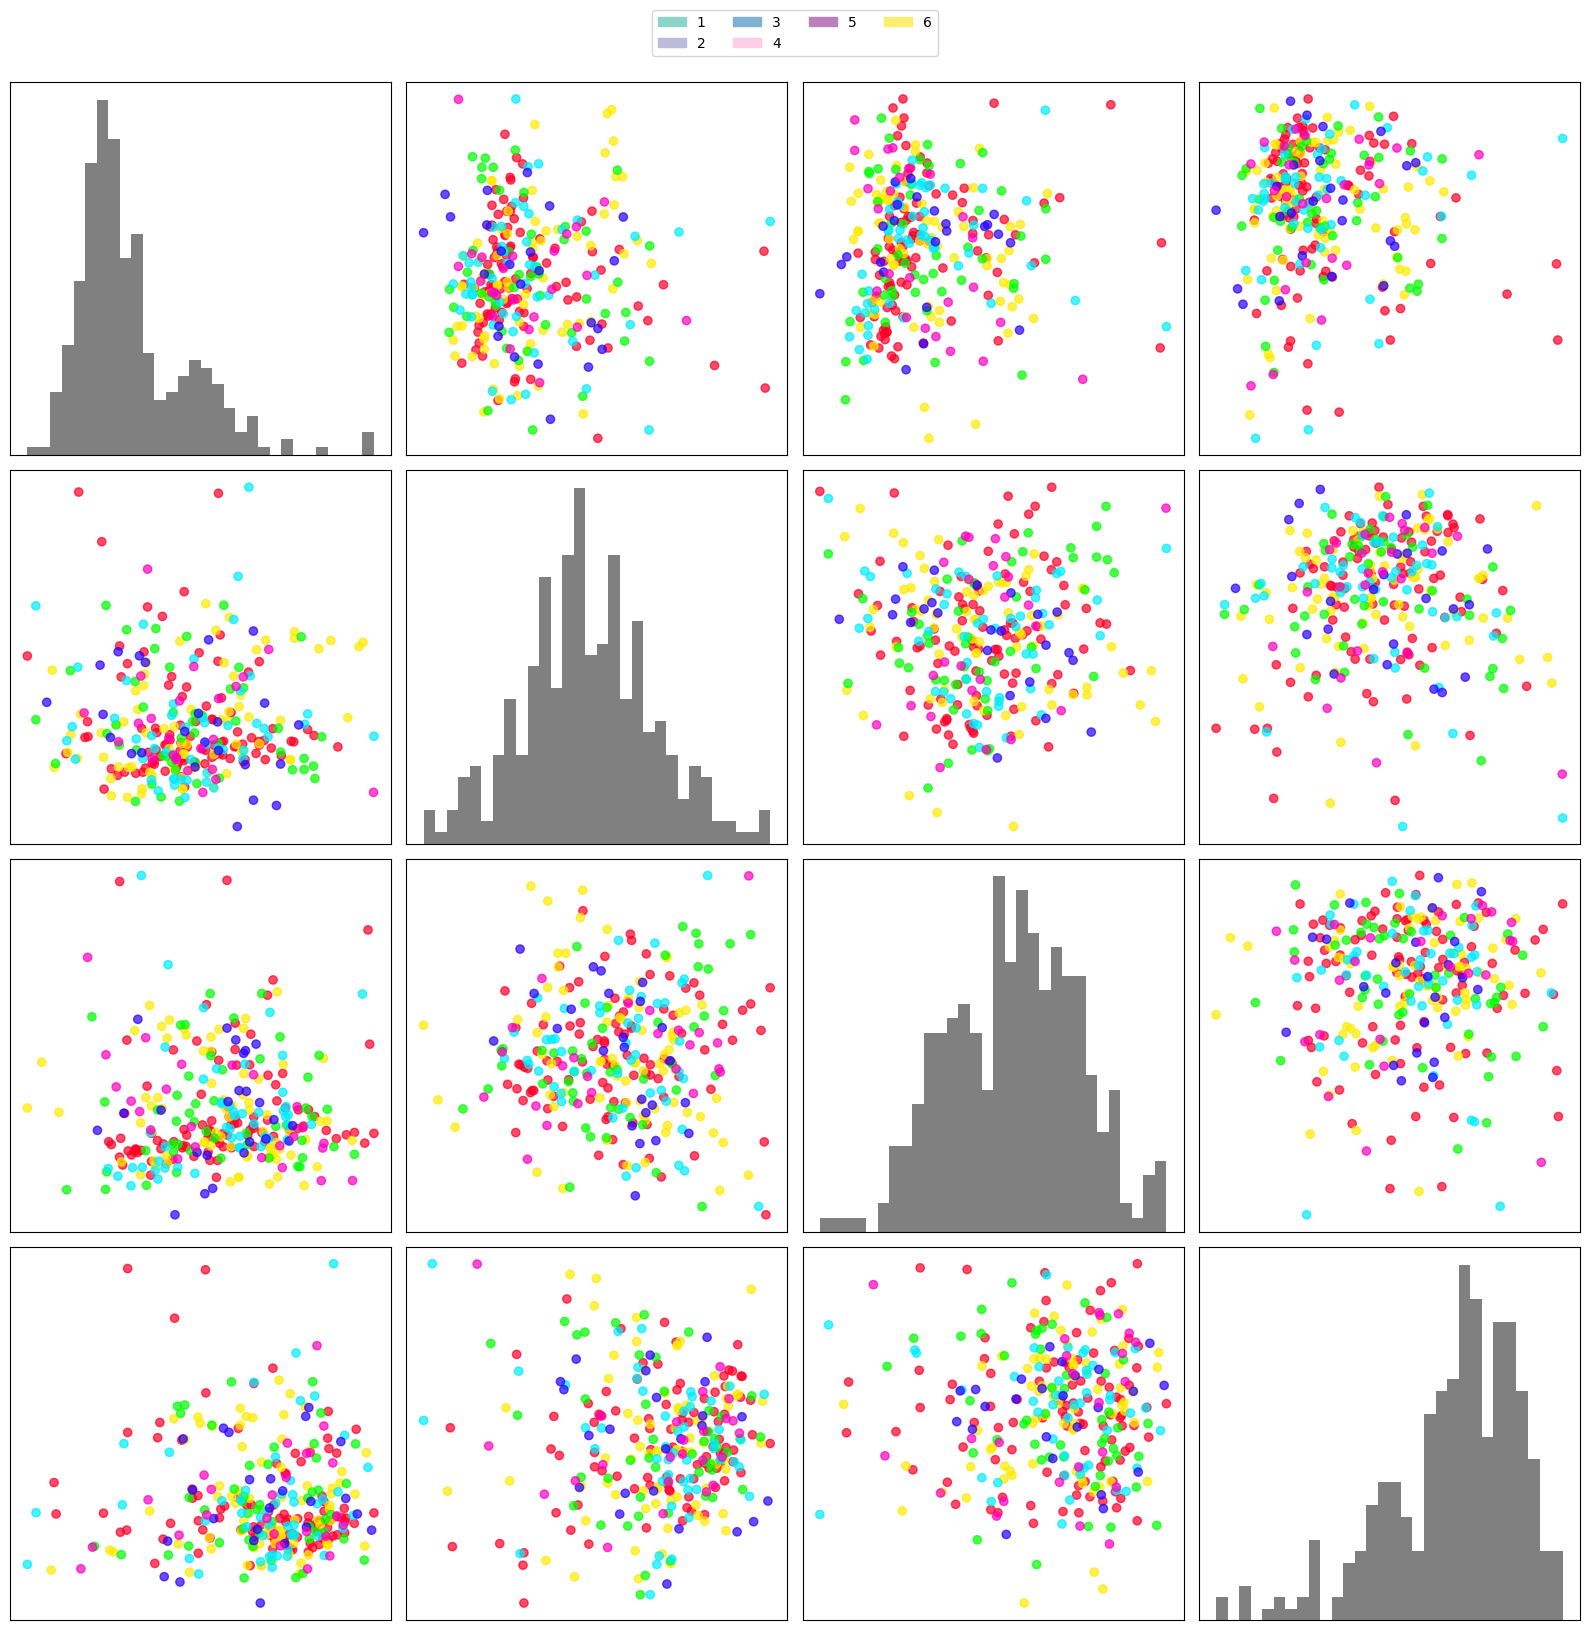

In [ ]:
pca = PCA()
signal_pca = pca.fit_transform(signal_data)

cohort_codes, cohort_labels = pd.factorize(Data_type['Cohort'].sort_values())
# Step 2: Create figure
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))

# Step 3: Scatter or histogram
for i in range(4):
    for j in range(4):
        ax = axs[i, j]
        pci = signal_pca[:, i]
        pcj = signal_pca[:, j]
        if i == j:
            ax.hist(pci, color='gray', bins=30)
        else:
            sc = ax.scatter(pci, pcj, c=cohort_codes, alpha=0.7, cmap='gist_rainbow')
        ax.set_xticks([])
        ax.set_yticks([])

# Step 4: Build manual legend
unique_codes = sorted(set(cohort_codes))
# We'll manually map code -> label (assuming label list hasn't been reordered)
label_map = {code: str(label) for code, label in enumerate(cohort_labels)}
# label_map[2] = 'Combined Cohorts'  # If you re-labeled 2–5 to 2, customize this
legend_handles = [Patch(color=plt.cm.Set3(code / max(unique_codes)), label=label_map[code])
                  for code in unique_codes]

# Step 5: Add shared legend
fig.legend(handles=legend_handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout(rect=[0, 0, 1, 0.98])  # Leave space for the legend
plt.show()

### Kernel PCA